## Part 2: Machine Learning and Statistical Modeling

---

In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel
import os
import tensorflow as tf
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=LinAlgWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score ,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Import clean dataset
IN_COLAB = False

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # mount our google drive
    drive.mount('/content/drive', force_remount=True)
    data_dir = "/content/drive/MyDrive/WM 23-24/DATA 340 NLP/NLP Final Project/datasets/"
else:
    data_dir = "datasets/"

data = pd.read_csv(str(data_dir) + "clean_movies.csv")

Mounted at /content/drive


### Convert movie descriptions and genres to BERT embeddings

---

In [3]:
data.head(5)

,id,title,genres,original_language,overview,popularity,release_date,budget,revenue,vote_average,vote_count
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,2023-08-02,129000000.0,352056482.0,7.079,1365.0
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,2023-04-05,18000000.0,65675816.0,7.433,545.0
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,2023-06-06,200000000.0,407045464.0,7.340,1007.0
3,693134,Dune: Part Two,Science Fiction-Adventure,en,Follow the mythic journey of Paul Atreides as ...,4742.163,2024-02-27,190000000.0,683813734.0,8.300,2770.0
4,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,2023-02-15,200000000.0,475766228.0,6.507,2811.0


### Subset train, validation, and test data

---

In [4]:
# Import tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = TFBertModel.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
# Define a function to encode movie descriptions
def BERTencode(text):
  encoded_input = tokenizer(text,
                          max_length=20,
                          padding='max_length',
                          truncation=True,
                          return_tensors='pt')
  return encoded_input

### Train and evaluate model performance

---

In [6]:
# Use BERT tokenizer to encode movie descriptions
movie_descs = data['overview'].tolist()
desc_encodings = BERTencode(movie_descs)
tf_desc_encodings = tf.data.Dataset.from_tensor_slices(desc_encodings)

In [ ]:
# Use batch processing to get BERT embeddings for the descriptions.
BATCH_SIZE = 100
batched_dataset = tf_desc_encodings.batch(BATCH_SIZE)

# Initialize a list to collect embeddings
embeddings_ls = []
po_embeddings_ls = []
# Process the batches with the BERT model
for i, batch in enumerate(batched_dataset):
    # Get input_ids, attention_mask, and token_type_ids from the batch
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    token_type_ids = batch['token_type_ids']

    # Call the BERT model with the inputs
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Get the embeddings
    embeddings = outputs.last_hidden_state
    po_embeddings = outputs.pooler_output
    # Save the embeddings
    embeddings_ls.append(embeddings.numpy())
    po_embeddings_ls.append(po_embeddings.numpy())
    print(f"Batch {i+1}/{(round(len(movie_descs)/BATCH_SIZE)+1)}..")
all_embeddings = tf.concat(embeddings_ls, axis=0)
all_po_embeddings = tf.concat(po_embeddings_ls,axis=0)

In [8]:
# # Create dataframe of embeddings
# desc_embeddings_df = pd.DataFrame(al_po_embeddings.numpy())
# desc_embeddings_df.shape

In [9]:
# Save embeddings to CSV for reproduciblity
# desc_embeddings_df.to_csv(data_dir + 'desc_embeddings.csv',index=False)

In [10]:
# Fetch movie description embeddings to avoid recalculating embeddings and reproducibility
desc_embeddings_df = pd.read_csv(data_dir + 'desc_embeddings.csv')

In [11]:
desc_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.872095,-0.444965,-0.691521,0.658000,0.322119,-0.055316,0.809087,0.208218,-0.421750,-0.999944,...,0.206775,-0.639241,0.947168,0.820933,-0.126723,0.592440,0.304356,-0.529498,-0.659013,0.804593
1,-0.503938,-0.269645,-0.359745,0.386152,-0.530743,0.058612,0.340306,0.352956,-0.158227,-0.999588,...,0.671995,-0.023991,0.652534,0.684764,0.046123,0.552250,0.662401,0.206972,-0.303011,0.610477
2,-0.735652,-0.405354,-0.448024,0.465486,0.079014,0.000954,0.184227,0.152845,-0.251872,-0.999877,...,0.278534,-0.646777,0.888124,0.801979,0.112830,0.809578,0.221723,-0.404869,-0.581707,0.473004
3,-0.847554,-0.465637,-0.921352,0.829712,0.666120,-0.087655,0.760439,0.376865,-0.836883,-0.999977,...,0.668992,-0.841865,0.983609,0.803294,-0.667125,0.210279,0.699460,-0.737261,-0.706764,0.707415
4,-0.871146,-0.509460,-0.904918,0.773120,0.695221,-0.190551,0.741391,0.293058,-0.689201,-0.999987,...,0.544987,-0.687181,0.962423,0.856463,-0.339481,0.354589,0.556867,-0.587696,-0.631134,0.786998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17097,-0.648341,-0.096644,0.608021,0.301342,-0.277870,-0.087319,0.626046,0.118061,0.480665,-0.997155,...,0.231670,0.474863,-0.529791,0.634047,-0.184424,0.641011,0.305759,0.362191,-0.453366,0.787515
17098,-0.596960,-0.546733,-0.954579,0.486651,0.567891,-0.252998,0.182673,0.510464,-0.708904,-0.999877,...,0.487144,-0.186031,0.972592,0.602272,-0.295889,0.043516,0.581159,-0.896837,-0.602785,0.584836
17099,-0.648341,-0.096644,0.608021,0.301342,-0.277870,-0.087319,0.626046,0.118061,0.480665,-0.997155,...,0.231670,0.474863,-0.529791,0.634047,-0.184424,0.641011,0.305759,0.362191,-0.453366,0.787515
17100,-0.878970,-0.332596,-0.279573,0.741598,-0.063681,-0.099573,0.864807,0.166725,-0.084737,-0.999971,...,0.553047,-0.274284,0.551111,0.893642,0.154285,0.717911,0.630187,-0.007907,-0.692915,0.907373


### Reformat other features

---

In [12]:
# Reformat and convert genres column into one hot encodings
# Split genres and identify unique genres
genres = data['genres'].tolist()
unique_genres = set()
for genre_str in genres:
    unique_genres.update(genre_str.split("-"))

# Convert unique genres to a list and sort it
unique_genres = sorted(list(unique_genres))

# Create a DataFrame with binary variables for each genre
genre_df = pd.DataFrame(0, columns=unique_genres, index=range(len(genres)))
for i, genre_str in enumerate(genres):
    for genre in genre_str.split("-"):
        genre_df.loc[i, genre] = 1
genre_df.shape

(17102, 20)

In [13]:
genre_df.head(3)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,none
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
# Reformat language column in similar format
lang_df = pd.get_dummies(data['original_language'].tolist())
lang_df.shape

(17102, 88)

In [15]:
lang_df.head(3)

,ab,af,am,ar,az,be,bg,bm,bn,bs,...,th,tl,tr,uk,ur,vi,xh,xx,zh,zu
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# Reformat release date column
release_dates = data['release_date']

# Convert release dates to datetime objects
release_dates_dt = pd.to_datetime(release_dates, errors='coerce')
# Extract year, month, and day features
years = [date.year for date in release_dates_dt]
months = [date.month for date in release_dates_dt]
days = [date.day for date in release_dates_dt]

# Handle missing or "no information" values
years = [year if not pd.isnull(year) else 0 for year in years]
months = [month if not pd.isnull(month) else 0 for month in months]
days = [day if not pd.isnull(day) else 0 for day in days]

# Concatenate the features into a DataFrame
release_date_df = pd.DataFrame({
    'year': years,
    'month': months,
    'day': days
})

release_date_df.shape

(17102, 3)

In [17]:
release_date_df.head(3)

,year,month,day
0,2023,8,2
1,2023,4,5
2,2023,6,6


In [18]:
# Combine features (BERT movie description embeddings, genres, release date, budget)
X = pd.concat([genre_df, (data['budget'])], axis=1)

# Concatenate BERT embeddings with other features
X = pd.concat([lang_df, X], axis=1)
X = pd.concat([release_date_df, X], axis=1)
X = pd.concat([desc_embeddings_df, X], axis=1)

# Subset y variables
y_revenue = data['revenue']
y_popularity = data['popularity']

In [19]:
# Make all column names string data types
col_names = X.columns.tolist()
col_names[:768] = [str(i) for i in range(0,768)]
X.columns = col_names

In [20]:
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,none,budget
0,-0.872095,-0.444965,-0.691521,0.658000,0.322119,-0.055316,0.809087,0.208218,-0.421750,-0.999944,...,0,0,0,1,0,0,0,0,0,129000000.0
1,-0.503938,-0.269645,-0.359745,0.386152,-0.530743,0.058612,0.340306,0.352956,-0.158227,-0.999588,...,0,1,0,0,0,1,0,0,0,18000000.0
2,-0.735652,-0.405354,-0.448024,0.465486,0.079014,0.000954,0.184227,0.152845,-0.251872,-0.999877,...,0,0,0,1,0,0,0,0,0,200000000.0


### Testing Statistical Models

---
Purpose of exploration: How well do regressive models predict movie revenue with movie description BERT embeddings and other categorical variables as input? More specifically, can statistical models still perform adequately and have useful predictions for movie revenue and popularity?

Outline of Exploration:
1. Test models on movie description BERT embeddings to predict movie revenue
2. Test models on movie description BERT embeddings to predict popularity
3. Test models on movie description BERT embeddings and other features including movie genres, language, release date, and budget to predict movie revenue
4. Test models on movie description BERT embeddings and other features including movie genres, language, release date, and budget to predict movie popularity
5. Reduce dimensionality of features using PCA and repeat steps 1-4

To simplify testing, it is necessary to initialize a function to run numerous statistical models and evaluate each one's performance on the inputted feature and target variables. This function runs the following statistical models:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Decision Tree Regression
- Support Vector Regression

Along with this, it evaluates the performance of each model by calculating the mean squared error, root mean squared error, mean absolute error, and R-squared score for each model. It then finds the best performing model for each metric and returns them in the end in the form of a tuple with the model name and the metric value. The other function following this creates visualizations for each metric for visual comparisions of each model.

In [21]:
def run_stat_models(features, target):
  # Train various regression models
  stat_models = {
      'Linear Regression': LinearRegression(),
      'Ridge Regression': Ridge(),
      'Lasso Regression': Lasso(),
      'Elastic Net Regression': ElasticNet(),
      'Decision Tree Regression': DecisionTreeRegressor(),
      'Support Vector Regression': SVR()
  }

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
  best_mse = (None, None)
  best_rmse = (None, None)
  best_mae = (None, None)
  best_r2 = (None, None)
  model_results_df = pd.DataFrame(columns=['model_name','mse','rmse','mae','r2_score'])

  # Train and test each model
  for name, model in stat_models.items():
    print(f"Running {name}..")
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict using the test set
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred) # Calculate MSE
    rmse = np.sqrt(mse) # Calculate RMSE
    mae = mean_absolute_error(y_test, y_pred) #Calculate MAE
    r2 = r2_score(y_test, y_pred) # Calculate R-squared score

    # Append results to dataframe
    model_results_df.loc[len(model_results_df.index)] = [name,mse,rmse,mae,r2]

    # Save best metrics
    if best_mse==(None,None) or mse < best_mse[1]:
      best_mse = (name,mse)
    if best_rmse==(None,None) or rmse < best_rmse[1]:
      best_rmse = (name,rmse)
    if best_mae==(None,None) or mae < best_mae[1]:
      best_mae = (name,mae)
    if best_r2==(None,None) or r2 > best_r2[1]:
      best_r2 = (name,r2)


    print("Model Results:")
    print("\tMean Squared Error:", mse)
    print("\tRoot Mean Squared Error:", rmse)
    print("\tMean Absolute Error:", mae)
    print("\tR-squared Score:", r2)
    print("\n")
  return model_results_df, best_mse, best_rmse, best_mae, best_r2

In [22]:
def visualize_results(model_results_df):
  # Create a 2x2 grid of subplots and add some padding in between the plots across width and height
  f,[(ax_1, ax_2), (ax_3, ax_4)] = plt.subplots(2, 2, figsize = (10,6),gridspec_kw = {'wspace':0.3,'hspace': 0.7})

  # Create a list of subplot axes for each metric
  subplots = [ax_1, ax_2, ax_3, ax_4]

  # Initialize lists of metrics to iterate through
  model_mse = model_results_df['mse']
  model_rmse = model_results_df['rmse']
  model_mae = model_results_df['mae']
  model_r2 = model_results_df['r2_score']
  metrics = [model_mse, model_rmse, model_mae, model_r2]

  # Initialize lists of titles and labels
  model_names = ['Linear Reg.','Ridge Reg.','Lasso Reg.','Elastic Net','Decision Tree','SVR']
  viz_titles = ["Mean Squared Error", "Root Mean Squared Error", "Mean Absolute Error", "R-Squared Score"]
  y_labels = ['Error','Error','Error', 'Score']
  colors = ['black','firebrick','seagreen','royalblue']

  # Plot the histogram for each metric
  for i, ax in enumerate(subplots):
    ax.plot(model_names,metrics[i],'o',color=colors[i])
    ax.plot(model_names,metrics[i],'--',color=colors[i])
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right',fontsize=8)
    ax.set_ylabel(y_labels[i])
    ax.set_title(f'{viz_titles[i]}',fontsize=10)

#### 1. Test models on movie description BERT embeddings to predict movie revenue

---

In [ ]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(desc_embeddings_df,y_revenue)

Running Linear Regression..
Model Results:
	Mean Squared Error: 1.4116141297836868e+16
	Root Mean Squared Error: 118811368.55468364
	Mean Absolute Error: 60849808.20051107
	R-squared Score: 0.07924797648042636


Running Ridge Regression..
Model Results:
	Mean Squared Error: 1.3809556615810908e+16
	Root Mean Squared Error: 117514069.86319089
	Mean Absolute Error: 58505313.58808744
	R-squared Score: 0.09924554241572658


Running Lasso Regression..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.067e+19, tolerance: 2.166e+16
  model = cd_fast.enet_coordinate_descent(


Model Results:
	Mean Squared Error: 1.4151264892678564e+16
	Root Mean Squared Error: 118959089.15538386
	Mean Absolute Error: 60893702.63209583
	R-squared Score: 0.07695697355395881


Running Elastic Net Regression..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+20, tolerance: 2.166e+16
  model = cd_fast.enet_coordinate_descent(


Model Results:
	Mean Squared Error: 1.4725074746556728e+16
	Root Mean Squared Error: 121346918.9825466
	Mean Absolute Error: 55818703.369409375
	R-squared Score: 0.03952914020159992


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 3.1904158507745452e+16
	Root Mean Squared Error: 178617352.20225793
	Mean Absolute Error: 72402682.19470493
	R-squared Score: -1.081009100496702


Running Support Vector Regression..
Model Results:
	Mean Squared Error: 1.68816256277319e+16
	Root Mean Squared Error: 129929310.11797108
	Mean Absolute Error: 41992767.31555374
	R-squared Score: -0.10113597116061324




In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Ridge Regression - 1.3809556615810908e+16
Best Root Mean Squared Error: Ridge Regression - 117514069.86319089
Best Mean Absolute Error: Support Vector Regression - 41992767.31555374
Best R-Squared Score: Ridge Regression - 0.09924554241572658


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,1.411614e+16,1.188114e+08,6.084981e+07,0.079248
1,Ridge Regression,1.380956e+16,1.175141e+08,5.850531e+07,0.099246
2,Lasso Regression,1.415126e+16,1.189591e+08,6.089370e+07,0.076957
3,Elastic Net Regression,1.472507e+16,1.213469e+08,5.581870e+07,0.039529
4,Decision Tree Regression,3.190416e+16,1.786174e+08,7.240268e+07,-1.081009
5,Support Vector Regression,1.688163e+16,1.299293e+08,4.199277e+07,-0.101136


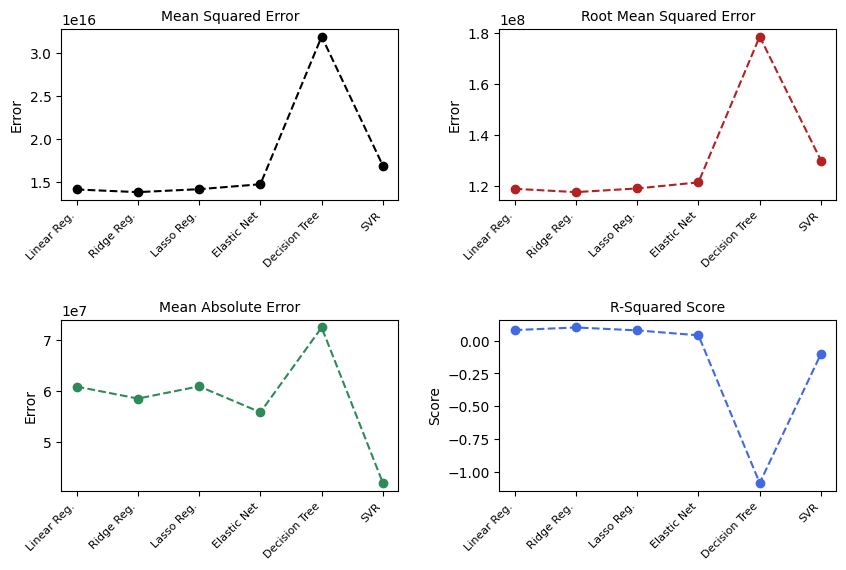

In [ ]:
visualize_results(model_results_df)

From the following output, we can see using the raw movie description embeddings did not result in a useful tool to predict movie revenue. This can be determined from the large MSE, RMSE, MAE, and very low R-squared score. Despite the Ridge model performing the best out of all the models tested, it did not perform well as seen from the metrics, hence it would not be a useful model for predicting movie revenue.

### 2. Test models on movie description BERT embeddings to predict popularity

---

In [ ]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(desc_embeddings_df,y_popularity)

Running Linear Regression..
Model Results:
	Mean Squared Error: 38715.56445700762
	Root Mean Squared Error: 196.76271104304195
	Mean Absolute Error: 35.143784554667086
	R-squared Score: -0.022933149963945354


Running Ridge Regression..
Model Results:
	Mean Squared Error: 38242.08052275946
	Root Mean Squared Error: 195.5558245687391
	Mean Absolute Error: 31.1900310749159
	R-squared Score: -0.010422873564498003


Running Lasso Regression..
Model Results:
	Mean Squared Error: 37840.07487951045
	Root Mean Squared Error: 194.52525512002407
	Mean Absolute Error: 21.421206233138406
	R-squared Score: 0.00019882095860901394


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 37842.48616009678
	Root Mean Squared Error: 194.53145288126746
	Mean Absolute Error: 21.493937425420313
	R-squared Score: 0.00013511069426930256


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 38910.05075089178
	Root Mean Squared Error: 197.25630725249772
	Mean Absolute Error: 24

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Lasso Regression - 37840.07487951045
Best Root Mean Squared Error: Lasso Regression - 194.52525512002407
Best Mean Absolute Error: Support Vector Regression - 17.66037290552426
Best R-Squared Score: Lasso Regression - 0.00019882095860901394


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,38715.564457,196.762711,35.143785,-0.022933
1,Ridge Regression,38242.080523,195.555825,31.190031,-0.010423
2,Lasso Regression,37840.074880,194.525255,21.421206,0.000199
3,Elastic Net Regression,37842.486160,194.531453,21.493937,0.000135
4,Decision Tree Regression,38910.050751,197.256307,24.989934,-0.028072
5,Support Vector Regression,37971.907108,194.863817,17.660373,-0.003284


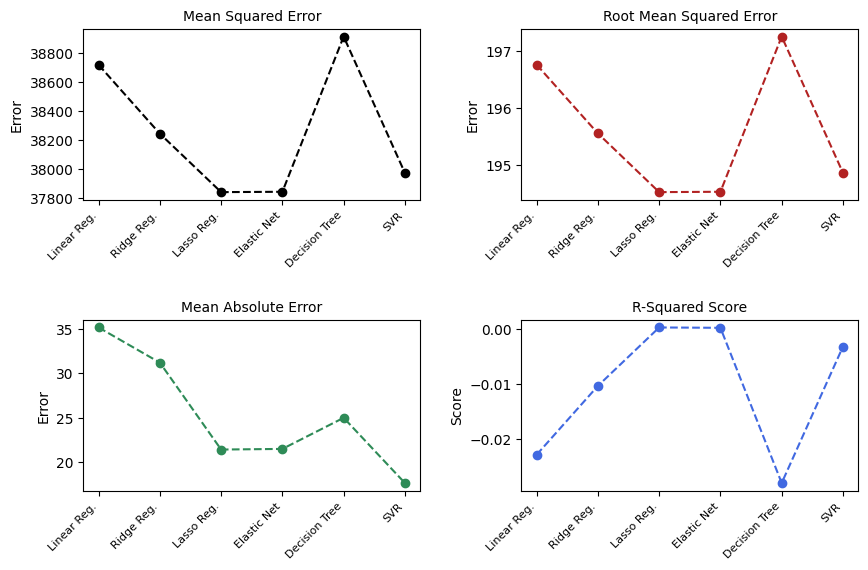

In [ ]:
visualize_results(model_results_df)

Overall, the combination of statistical models and movie description BERT embeddings was not successful for predicting movie popularity. The Lasso regression model turned out to be the best model out of all the models tested, however it still performed really poorly, as determined from the metrics. From this testing, we can determine a statistical model would not be the best model for predicting movie popularity with movie description BERT embeddings.

### 3. Test models on movie description BERT embeddings and other features including movie genres, language, release date, and budget to predict movie revenue

---

In [ ]:
# Run multiple statistical models for movie revenue prediction with all features
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(X,y_revenue)

Running Linear Regression..
Model Results:
	Mean Squared Error: 1.0407265130418398e+16
	Root Mean Squared Error: 102016004.28569233
	Mean Absolute Error: 53172070.60503682
	R-squared Score: 0.3211664415964832


Running Ridge Regression..


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.64498e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Results:
	Mean Squared Error: 1.013349758089141e+16
	Root Mean Squared Error: 100665274.95065719
	Mean Absolute Error: 50806994.677919
	R-squared Score: 0.3390234479753862


Running Lasso Regression..
Model Results:
	Mean Squared Error: 1.041627993649348e+16
	Root Mean Squared Error: 102060178.01519592
	Mean Absolute Error: 53092545.928538375
	R-squared Score: 0.32057843381445983


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 1.0072198953828308e+16
	Root Mean Squared Error: 100360345.52465585
	Mean Absolute Error: 43133812.714666806
	R-squared Score: 0.34302176690096764


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 1.4807541664392406e+16
	Root Mean Squared Error: 121686242.70800872
	Mean Absolute Error: 44926763.69438761
	R-squared Score: 0.034150079460527616


Running Support Vector Regression..
Model Results:
	Mean Squared Error: 1.6881497361506498e+16
	Root Mean Squared Error: 129928816.51699325
	Mean Absolute Error: 41992369.

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Elastic Net Regression - 1.0072198953828308e+16
Best Root Mean Squared Error: Elastic Net Regression - 100360345.52465585
Best Mean Absolute Error: Support Vector Regression - 41992369.32913407
Best R-Squared Score: Elastic Net Regression - 0.34302176690096764


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,1.040727e+16,1.020160e+08,5.317207e+07,0.321166
1,Ridge Regression,1.013350e+16,1.006653e+08,5.080699e+07,0.339023
2,Lasso Regression,1.041628e+16,1.020602e+08,5.309255e+07,0.320578
3,Elastic Net Regression,1.007220e+16,1.003603e+08,4.313381e+07,0.343022
4,Decision Tree Regression,1.480754e+16,1.216862e+08,4.492676e+07,0.034150
5,Support Vector Regression,1.688150e+16,1.299288e+08,4.199237e+07,-0.101128


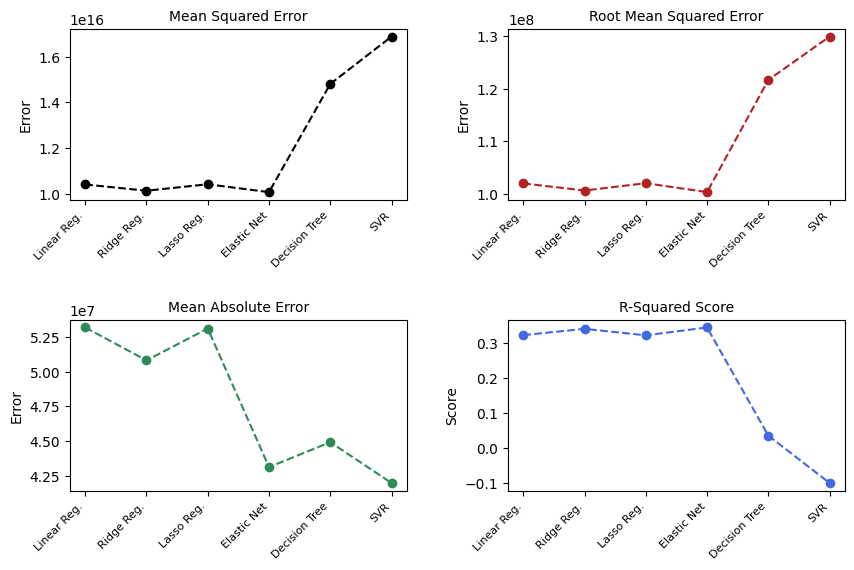

In [ ]:
visualize_results(model_results_df)

From the following output, we can see there was an improvement in the performance of some models. The best performing model in this particular analysis was the Elastic Net model, with an R-squared score of 0.34. Although, comparitively the model performance was good, its metric results still indicate it would not be a good model for predicting revenue.

### 4. Test models on movie description BERT embeddings and other features including movie genres, language, release date, and budget to predict movie popularity

---

In [ ]:
# Run multiple statistical models for movie popularity
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(X,y_popularity)

Running Linear Regression..
Model Results:
	Mean Squared Error: 38154.818962885176
	Root Mean Squared Error: 195.33258551221087
	Mean Absolute Error: 35.12308943088157
	R-squared Score: -0.008117270028429102


Running Ridge Regression..
Model Results:
	Mean Squared Error: 37669.266632445804
	Root Mean Squared Error: 194.0857198055689
	Mean Absolute Error: 31.068273627654875
	R-squared Score: 0.0047118745756804525


Running Lasso Regression..
Model Results:
	Mean Squared Error: 37258.11624608005
	Root Mean Squared Error: 193.02361577299305
	Mean Absolute Error: 19.24988943453275
	R-squared Score: 0.015575189258876021


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 37284.72155721753
	Root Mean Squared Error: 193.09252071796445
	Mean Absolute Error: 19.240622109092822
	R-squared Score: 0.01487223025235418


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 37347.28763555281
	Root Mean Squared Error: 193.2544634298334
	Mean Absolute Error: 19.846

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Lasso Regression - 37258.11624608005
Best Root Mean Squared Error: Lasso Regression - 193.02361577299305
Best Mean Absolute Error: Support Vector Regression - 16.283202244495413
Best R-Squared Score: Lasso Regression - 0.015575189258876021


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,38154.818963,195.332586,35.123089,-0.008117
1,Ridge Regression,37669.266632,194.085720,31.068274,0.004712
2,Lasso Regression,37258.116246,193.023616,19.249889,0.015575
3,Elastic Net Regression,37284.721557,193.092521,19.240622,0.014872
4,Decision Tree Regression,37347.287636,193.254463,19.846845,0.013219
5,Support Vector Regression,37481.834580,193.602259,16.283202,0.009664


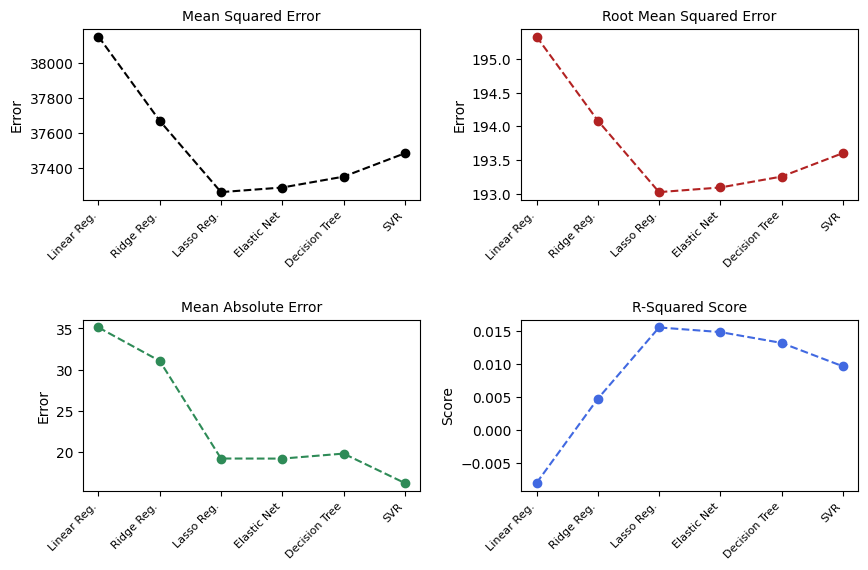

In [ ]:
visualize_results(model_results_df)

From the output, we can see we get similar results to the model performance on just the movie description embeddings. Again, it is apparent from these results that predicting movie popularity would not be useful with a statistical model.

### 5. Reduce dimensionality of features using PCA and repeat steps 1-4

---

Out of pure curiousity, I wanted to see if reducing the dimensionality of the features and movie description embeddings would help in the performance of the model. Although this would mean loosing most of the nuanced, complexity given by the BERT embeddings, still wanted ot know if it would benefit predictions, especially in the case of predicting movie popularity.

In [23]:
# Perform dimensionality reduction on data using PCA
pca = PCA(n_components=10)  # Reduce to 10 principal components
X_pca = pca.fit_transform(X)
embeddings_pca = pca.fit_transform(desc_embeddings_df)

### Predict movie revenue on PCA movie description BERT embeddings

---

In [24]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(embeddings_pca,y_revenue)

Running Linear Regression..
Model Results:
	Mean Squared Error: 1.4733882827197478e+16
	Root Mean Squared Error: 121383206.52873476
	Mean Absolute Error: 56059527.47408917
	R-squared Score: 0.03895461647714993


Running Ridge Regression..
Model Results:
	Mean Squared Error: 1.4733894652285988e+16
	Root Mean Squared Error: 121383255.23846355
	Mean Absolute Error: 56059001.71520201
	R-squared Score: 0.038953845163379186


Running Lasso Regression..
Model Results:
	Mean Squared Error: 1.4733882838492166e+16
	Root Mean Squared Error: 121383206.57525969
	Mean Absolute Error: 56059527.18412734
	R-squared Score: 0.038954615740432574


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 1.4917180707813844e+16
	Root Mean Squared Error: 122135910.8035546
	Mean Absolute Error: 56296242.41718132
	R-squared Score: 0.02699866541917706


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 3.0633843126449412e+16
	Root Mean Squared Error: 175025264.25190568
	Mean Abs

In [25]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Linear Regression - 1.4733882827197478e+16
Best Root Mean Squared Error: Linear Regression - 121383206.52873476
Best Mean Absolute Error: Support Vector Regression - 41992744.65701499
Best R-Squared Score: Linear Regression - 0.03895461647714993


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,1.473388e+16,1.213832e+08,5.605953e+07,0.038955
1,Ridge Regression,1.473389e+16,1.213833e+08,5.605900e+07,0.038954
2,Lasso Regression,1.473388e+16,1.213832e+08,5.605953e+07,0.038955
3,Elastic Net Regression,1.491718e+16,1.221359e+08,5.629624e+07,0.026999
4,Decision Tree Regression,3.063384e+16,1.750253e+08,6.782742e+07,-0.998150
5,Support Vector Regression,1.688161e+16,1.299293e+08,4.199274e+07,-0.101135


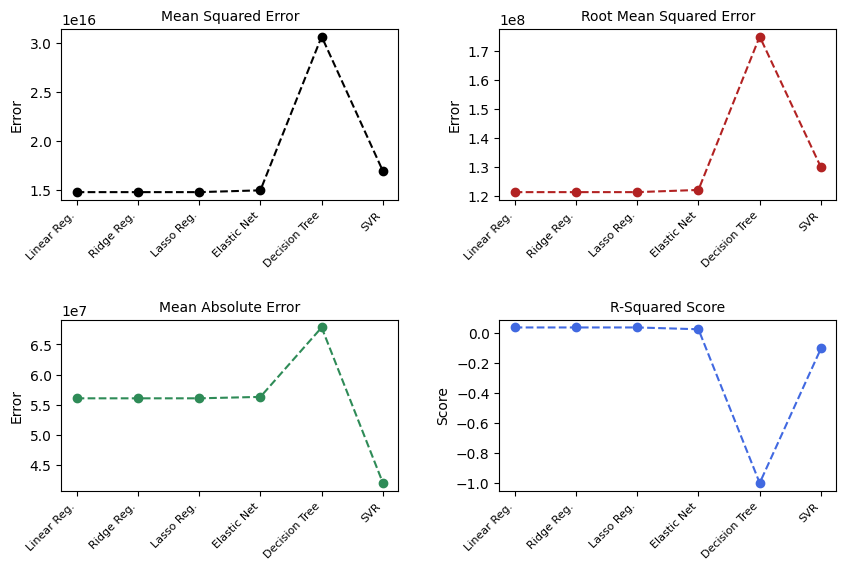

In [26]:
visualize_results(model_results_df)

With our previous non-transformed embeddings, the best model was a Ridge Regression model with an R-squared score of 0.09924554241572658. After the PCA transformation, the R-squared score for Ridge went down to 0.03893068061170524, indicating that the model performance was worse. In this analysis, the best model was simple Linear Regression with an R-squared score of 0.03893145128403075. Since this score is still less than the original Ridge Regression R-squared score, it would be better to stick with the non-transformed embeddings for a better model performance. In either case however, these models should not be used for predicting movie revenue due to their poor metric results.

### Predict movie popularity on PCA movie description BERT embeddings

---

In [ ]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(embeddings_pca,y_popularity)

Running Linear Regression..
Model Results:
	Mean Squared Error: 37773.91366255883
	Root Mean Squared Error: 194.35512255291556
	Mean Absolute Error: 21.337000512176118
	R-squared Score: 0.0019469164083583124


Running Ridge Regression..
Model Results:
	Mean Squared Error: 37773.91990135615
	Root Mean Squared Error: 194.35513860290948
	Mean Absolute Error: 21.336661031663898
	R-squared Score: 0.0019467515683854186


Running Lasso Regression..
Model Results:
	Mean Squared Error: 37785.50224394913
	Root Mean Squared Error: 194.38493317114145
	Mean Absolute Error: 21.176580777786434
	R-squared Score: 0.0016407257527021324


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 37818.77892762953
	Root Mean Squared Error: 194.47050914632155
	Mean Absolute Error: 21.251330042918344
	R-squared Score: 0.000761497376854936


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 46649.75683412502
	Root Mean Squared Error: 215.98554774365118
	Mean Absolute Error: 25

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Linear Regression - 37773.91366255883
Best Root Mean Squared Error: Linear Regression - 194.35512255291556
Best Mean Absolute Error: Support Vector Regression - 17.840002941096703
Best R-Squared Score: Linear Regression - 0.0019469164083583124


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,37773.913663,194.355123,21.337001,0.001947
1,Ridge Regression,37773.919901,194.355139,21.336661,0.001947
2,Lasso Regression,37785.502244,194.384933,21.176581,0.001641
3,Elastic Net Regression,37818.778928,194.470509,21.251330,0.000761
4,Decision Tree Regression,46649.756834,215.985548,25.948281,-0.232568
5,Support Vector Regression,37979.305280,194.882799,17.840003,-0.003480


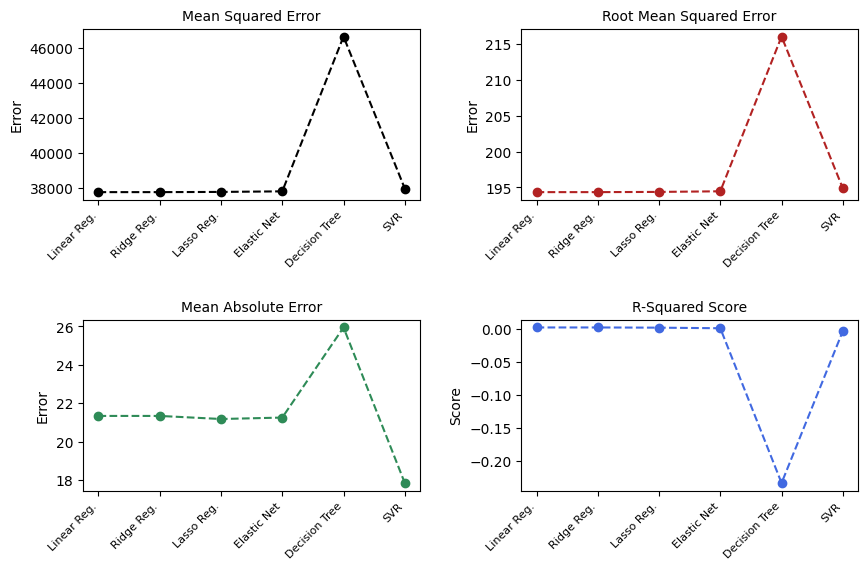

In [ ]:
visualize_results(model_results_df)

From these results, we can also see reducing the dimensionality did not make our model better. Compared to the best model of the non-transformed embeddings, Lasso Regression with an R-squared score of 0.00019882095860901394, our model performance did not get much better. This adds more support to the same conclusion we have been seeing. That another model is needed to make better predictions about movie popularity.

### Predict movie revenue using PCA transformed features

---

In [ ]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(X_pca,y_revenue)

Running Linear Regression..
Model Results:
	Mean Squared Error: 1.0390897549975244e+16
	Root Mean Squared Error: 101935752.06950329
	Mean Absolute Error: 44232956.7774911
	R-squared Score: 0.32223404799791966


Running Ridge Regression..
Model Results:
	Mean Squared Error: 1.0390894486925282e+16
	Root Mean Squared Error: 101935737.04508778
	Mean Absolute Error: 44232925.51377937
	R-squared Score: 0.3222342477911486


Running Lasso Regression..
Model Results:
	Mean Squared Error: 1.0390897538280266e+16
	Root Mean Squared Error: 101935752.01213883
	Mean Absolute Error: 44232956.68471019
	R-squared Score: 0.3222340487607468


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 1.0385441999717638e+16
	Root Mean Squared Error: 101908988.80725703
	Mean Absolute Error: 44195316.02197351
	R-squared Score: 0.32258989658522963


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 1.2884522366451826e+16
	Root Mean Squared Error: 113510009.98348923
	Mean Absolut

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Elastic Net Regression - 1.0385441999717638e+16
Best Root Mean Squared Error: Elastic Net Regression - 101908988.80725703
Best Mean Absolute Error: Support Vector Regression - 41992355.50141517
Best R-Squared Score: Elastic Net Regression - 0.32258989658522963


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,1.039090e+16,1.019358e+08,4.423296e+07,0.322234
1,Ridge Regression,1.039089e+16,1.019357e+08,4.423293e+07,0.322234
2,Lasso Regression,1.039090e+16,1.019358e+08,4.423296e+07,0.322234
3,Elastic Net Regression,1.038544e+16,1.019090e+08,4.419532e+07,0.322590
4,Decision Tree Regression,1.288452e+16,1.135100e+08,4.236606e+07,0.159583
5,Support Vector Regression,1.688149e+16,1.299288e+08,4.199236e+07,-0.101127


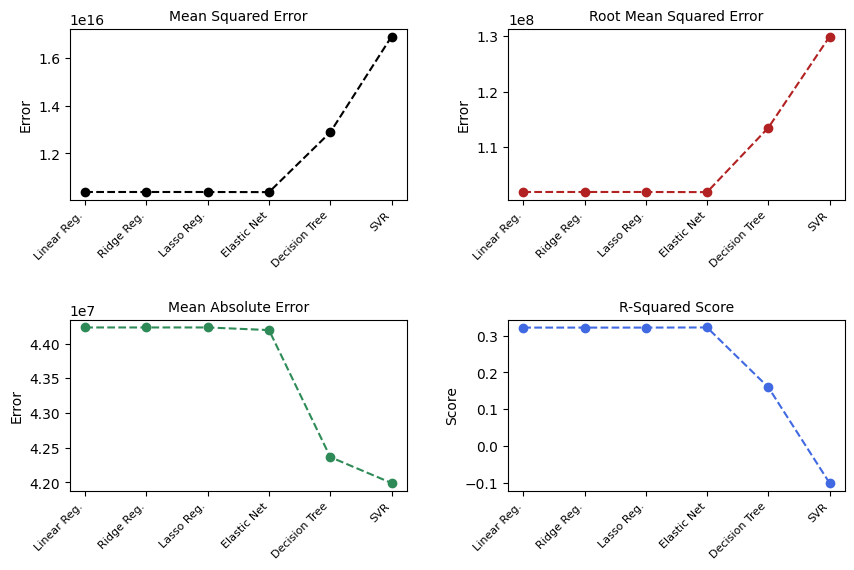

In [ ]:
visualize_results(model_results_df)

From the following results, we can see the performance of our best model got slightly worse after reducing the dimensionality of the features. Our Elastic Net R-squared score went down from 0.34302176690096764 to 0.32258989658522963, indicating that it would be best to stick with the non-transformed features for better results.

### Predict movie popularity using PCA transformed features

---

In [ ]:
model_results_df, best_mse, best_rmse, best_mae, best_r2 = run_stat_models(X_pca,y_popularity)

Running Linear Regression..
Model Results:
	Mean Squared Error: 37353.59724490346
	Root Mean Squared Error: 193.2707873552117
	Mean Absolute Error: 19.42886309072414
	R-squared Score: 0.013052413722525635


Running Ridge Regression..
Model Results:
	Mean Squared Error: 37353.59621701999
	Root Mean Squared Error: 193.27078469603208
	Mean Absolute Error: 19.42886354330218
	R-squared Score: 0.01305244088101054


Running Lasso Regression..
Model Results:
	Mean Squared Error: 37347.79543966874
	Root Mean Squared Error: 193.25577724784515
	Mean Absolute Error: 19.444848760639733
	R-squared Score: 0.013205707597675476


Running Elastic Net Regression..
Model Results:
	Mean Squared Error: 37348.734675548214
	Root Mean Squared Error: 193.25820726568952
	Mean Absolute Error: 19.45296308603124
	R-squared Score: 0.01318089133759448


Running Decision Tree Regression..
Model Results:
	Mean Squared Error: 46476.28450658692
	Root Mean Squared Error: 215.58359053180953
	Mean Absolute Error: 23.6294743

In [ ]:
# Look into the results
print(f"Best Mean Squared Error: {best_mse[0]} - {best_mse[1]}")
print(f"Best Root Mean Squared Error: {best_rmse[0]} - {best_rmse[1]}")
print(f"Best Mean Absolute Error: {best_mae[0]} - {best_mae[1]}")
print(f"Best R-Squared Score: {best_r2[0]} - {best_r2[1]}")
model_results_df

Best Mean Squared Error: Lasso Regression - 37347.79543966874
Best Root Mean Squared Error: Lasso Regression - 193.25577724784515
Best Mean Absolute Error: Support Vector Regression - 16.28046454850485
Best R-Squared Score: Lasso Regression - 0.013205707597675476


,model_name,mse,rmse,mae,r2_score
0,Linear Regression,37353.597245,193.270787,19.428863,0.013052
1,Ridge Regression,37353.596217,193.270785,19.428864,0.013052
2,Lasso Regression,37347.795440,193.255777,19.444849,0.013206
3,Elastic Net Regression,37348.734676,193.258207,19.452963,0.013181
4,Decision Tree Regression,46476.284507,215.583591,23.629474,-0.227985
5,Support Vector Regression,37482.897592,193.605004,16.280465,0.009636


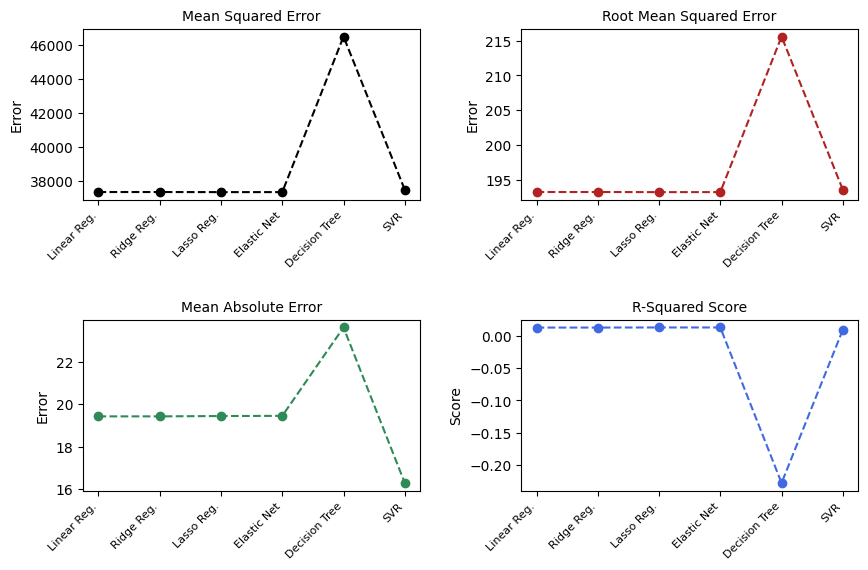

In [ ]:
visualize_results(model_results_df)

From our results we can see the model performance of our best model did not get better or worse. This indicates it may be better to stick with the transformed features for a faster, less expensive runtime. Overall, it is not recommended to use these models for predictions since they all performed poorly.